In [1]:
import pandas as pd
import numpy as np
import datatable as dt
import gc
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes("pastel") # 颜色设定
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
sns.set_color_codes("muted")

In [2]:
def LoadTables(filename, sepstr, usecols):
    dt_df = dt.fread(filename, sep=sepstr, header=True, columns=usecols, fill=True)
    df  = dt_df.to_pandas()
    del dt_df
    gc.collect()
    return(df)

# Filter
def FilterDF(VDF_DF, region, filter_Frag):
    ## region filter
    print("Befor filter : %d"%len(VDF_DF))
    Pchr = VDF_DF.chrom == region[0]
    Pregion = (VDF_DF.start >= region[1]) & (VDF_DF.end <= region[2])
    VDF_filter = VDF_DF.loc[ Pchr & Pregion , :]
    print("After Region Filter: %d"%len(VDF_filter) )
    ## fragment filter
    Fragmentcount = VDF_filter.groupby(by="read_name", as_index=True)["chrom"].count()
    VDF_filter = VDF_filter.set_index("read_name")
    VDF_filter["Fragnum"] = 0
    VDF_filter.loc[:, "Fragnum"] = Fragmentcount.loc[VDF_filter.index]
    VDF_filter = VDF_filter.loc[VDF_filter.Fragnum>=filter_Frag, :] 
    print("After Fragment number Filter: %d"%len(VDF_filter) )
    return (VDF_filter)

# Bins 
def BinsDF(df, binsize=5000):
    df = df.reset_index()
    df["pos"] = (df.start.values + df.end.values)/2
    df["pos"] = df["pos"].astype("int")
    df["bin"] =  ( df["pos"].values/binsize ).astype("int")
    #df = df.drop(["start", "end", "Fragnum"], axis=1)
    return (df)

# Loading
def Loading(filename, region, filter_Frag, binsize = 5000):
    #filename = "/data1/ZJY/Pore-C/NA12878/NA12878_Rep6/vdFAnnotation/Merge_Align_Fragment_RvdF.csv"
    print("Loading %s"%filename)
    usecols = {"read_name","read_start","read_end","strand","chrom","start","end","MapQual","LRvdF_pfix"}
    VDF_DF = LoadTables(filename, ",",  usecols)
    VDF_DF.columns = ["read_name","read_start","read_end","strand","chrom","start","end","MapQual","LRvdF_pfix"]
    VDF_filter = FilterDF(VDF_DF, region, filter_Frag)
    del(VDF_DF)
    gc.collect()
    # Bin calculate
    bin_df = BinsDF(VDF_filter, binsize)
    del(VDF_filter)
    return(bin_df)

# Loading bed
def Loadingbed(filename, region, binsize, colnames = ["chrom", "start", "end", "value"], usecols = [0,1,2,3] ):
    print("Loading %s"%filename)
    sepstr = "\t"
    bedDF = pd.read_table(filename, sep=sepstr, header=None, usecols=usecols)
    bedDF.columns = colnames
    Pchr = bedDF.chrom == region[0]
    Pregion = (bedDF.start >= region[1]) & (bedDF.end <= region[2])
    bedDF = bedDF.loc[Pchr&Pregion,:]
    bedDF = BinsDF(bedDF, binsize)
    return(bedDF)


In [3]:
# Loading datas
# Loading read fragment annotation and filter
# Filter 
filter_Frag =  2
binsize = 5000
## region
region = ["chr11", 70180000,70500000]
filename = "/data1/ZJY/Pore-C/Analysis/NA12878/Merge_NA12878/vdFAnnotation/Merge_Align_Fragment_RvdF_5Reps.%s.csv"%region[0]
binVDF = Loading(filename, region, filter_Frag, binsize)

Loading /data1/ZJY/Pore-C/Analysis/NA12878/Merge_NA12878/vdFAnnotation/Merge_Align_Fragment_RvdF_5Reps.chr11.csv
Befor filter : 20862956
After Region Filter: 54439
After Fragment number Filter: 35873


In [4]:
# loading CTCF bed
ctcffile="/data1/ZJY/Pore-C/HiGlass/Encode/GM12878_CTCF_IDR_peaks_ENCFF635MMB.bedGraph"
bedDF = Loadingbed(ctcffile, region, binsize, ["chrom", "start", "end", "value"] )
bedDF = bedDF.set_index("bin")
bedDF.head()

Loading /data1/ZJY/Pore-C/HiGlass/Encode/GM12878_CTCF_IDR_peaks_ENCFF635MMB.bedGraph


,index,chrom,start,end,value,pos
bin,,,,,,
14038,7611,chr11,70191678,70191771,219.34921,70191724
14039,7612,chr11,70196193,70196358,281.76919,70196275
14054,7613,chr11,70270375,70270591,34.02339,70270483
14084,7614,chr11,70421218,70421434,78.40822,70421326
14091,7615,chr11,70457189,70457405,33.55469,70457297


In [5]:
# ctcf bin match
ctcfbins = set( bedDF.index.values )
binVDF["binfind"] = 0
binVDF.loc[ binVDF.bin.isin( ctcfbins ),"binfind"] = 1
binVDF.head()

,read_name,read_start,read_end,strand,chrom,start,end,MapQual,LRvdF_pfix,Fragnum,pos,bin,binfind
0,80c6572a-dfdf-40da-9428-95b57824239b,2591,2745,+,chr11,70346637,70346790,60.0,True,2,70346713,14069,0
1,80c6572a-dfdf-40da-9428-95b57824239b,2745,4144,-,chr11,70341385,70342784,60.0,True,2,70342084,14068,0
2,0b1c1c2b-96d7-40a5-a80f-d3a2fe386da3,26,926,-,chr11,70331013,70331912,60.0,True,2,70331462,14066,0
3,0b1c1c2b-96d7-40a5-a80f-d3a2fe386da3,926,4971,-,chr11,70286818,70290884,60.0,True,2,70288851,14057,0
4,a4990233-6afa-4dd3-9dab-630cf6ba9bec,124,1109,-,chr11,70359255,70360250,60.0,True,4,70359752,14071,0


In [6]:
# Bin Matrix
binsize=5000
readnames = list( set( binVDF.read_name.to_list() ) )
Ts, Te = round(region[1]/binsize), round( region[2]/binsize + 1 )
BinIds = [ idx for idx in range( Ts, Te ) ]

FragMatrix = pd.DataFrame( np.zeros( [len(BinIds), len(readnames)], dtype=int ), 
                          index = BinIds,
                          columns = readnames)
binVDF_group = binVDF.groupby("read_name")
for read_name, df in binVDF_group:
    P = (df.bin>= Ts) & (df.bin<Te)
    FragMatrix.loc[ df.loc[P,"bin"].values, read_name ] = 1

In [7]:
# Cluster region fragments >= 2
FragSelect="mdLRMFs"
if FragSelect == "All":
    c_frag_num = 2
    cluster_P = FragMatrix.sum() >= c_frag_num
elif FragSelect == "lwLRMFs":
    c_frag_num = 3
    cluster_P = FragMatrix.sum() <= c_frag_num
elif FragSelect == "mdLRMFs":
    cfnl, cfnh = 4, 50
    cluster_P = ( FragMatrix.sum() <= cfnh ) & ( FragMatrix.sum() >= cfnl )
elif FragSelect == "hgLRMFs":
    cfnl = 7
    cluster_P =  FragMatrix.sum() >= cfnl 
    
cluster_reads = cluster_P.loc[cluster_P==True].index.to_list()
FragMatrix_filter = FragMatrix.loc[:, cluster_reads]
print( "%d %s reads in %d all reads in cluster region." %(len(cluster_reads), FragSelect, len(readnames)) )

1813 mdLRMFs reads in 12111 all reads in cluster region.


In [8]:
FragMatrix_filter.head(10)

,141c4047-558a-45cf-b83f-7da47b14fd23,f6cb3368-7290-435e-af01-ff796884f62e,2354286e-3a0a-489f-a5cf-11f238016864,9dd15a89-a05a-491a-9894-3efad5a3667f,a3254feb-761d-4cdd-90cb-fe7d21926bec,523043ab-0e5e-4804-a215-5b3353375b87,7700cc57-9624-437e-8129-677120c8fc86,908002dd-eb90-4fa7-9a6a-3184c8231d11,2c31fa75-285f-4865-a3ca-fd9cb4ea9368,c3c0ba5f-eab1-416b-996c-c814e96945cb,...,21490c0e-a0b0-4a4b-bd6b-d72aa01bad3a,55b77d7b-6868-4e8e-81a0-4099a52e4075,a3250641-afdd-4b9d-bb7b-6d92eb4eb23a,bcd7af58-7e3f-4559-8a53-78c6dcb8c329,a45f2604-1fa4-4fc2-b8bb-35b4b8caf698,f095d94c-11bd-4490-b24a-703de68aba93,02673f23-4102-4413-a330-e390183ba8c2,47412315-01b0-4c68-8d0c-8fa7b05d473a,50ade078-ed3e-4f0c-8216-4ed222a32357,ea1083f6-44fa-48d2-b3fe-0183ed762da8
14036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
14037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
14040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14042,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14043,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
14044,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
14045,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The number of clusters: 3


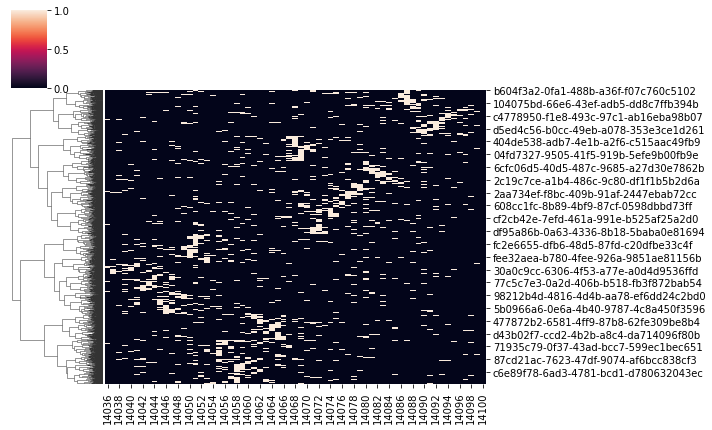

In [9]:
## hierarchy cluster
import seaborn as sns
import scipy
import scipy.cluster.hierarchy as sch

# Cluster
clusterDF = sns.clustermap(data=FragMatrix_filter.T, metric="euclidean", method="ward", figsize=(10,6), col_cluster=False)
# export
## cluster branch tree order
dist_thred = 18
Z = clusterDF.dendrogram_row.calculated_linkage
T = sch.fcluster(Z, t=dist_thred, criterion='distance')
print("The number of clusters: %d"%max(T) )

In [45]:
# export
## cluster branch tree order
dist_thred = 18
Z = clusterDF.dendrogram_row.calculated_linkage
T = sch.fcluster(Z, t=dist_thred, criterion='distance')
print("The number of clusters: %d"%max(T) )

The number of clusters: 3


In [10]:
## cluster leaves order index
reorder_idx = clusterDF.dendrogram_row.reordered_ind
read_names_order = FragMatrix_filter.iloc[:, reorder_idx].columns.to_list()
## tree branch and leaves diction
Tdic = {}
#T = list(T)[::-1]
for i in range( len(T ) ):
    Tdic[ FragMatrix_filter.columns[i] ] = T[i]
    
# hierarchy cluster_reads 
order_DF = binVDF.set_index("read_name", drop=False).loc[read_names_order]
order_DF["Cluster"] = order_DF["read_name"].apply(lambda x: Tdic[x]) 
readorder = dict()
readidx = 0
for rn in read_names_order:
    readorder[rn] = readidx
    readidx += 1 
order_DF["read_order"] =  order_DF["read_name"].apply(lambda x: readorder[x] )
order_DF = order_DF.reset_index(drop=True)
# start end
order_DF.loc[:, "start"] = (order_DF.bin.values*binsize - 0.5*binsize).astype(int)
order_DF.loc[:, "end"] = (order_DF.bin.values*binsize + 0.5*binsize).astype(int)

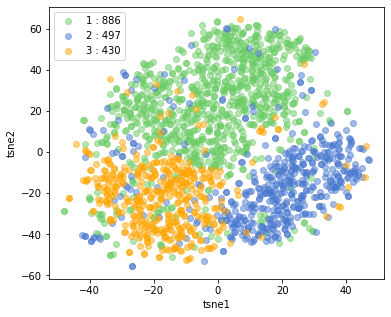

In [11]:
import numpy as np
from numpy import unique
#from sklearn.mixture import GaussianMixture
#X = np.array( FragMatrix_filter.T )
#n_clusters_ = 3
#model = GaussianMixture(n_components=n_clusters_, random_state=10)
#model.fit(X)
#T  = model.predict(X) # labels

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform( FragMatrix_filter.T ) 
plt.figure(figsize=(6, 5))
colors = ["k","g", "b", "orange", "c", "purple",  "y", "navy"]
target_ids = range(1, T.max() + 1 )

legendlist = []
for i, c, label in zip(target_ids, colors[1:], target_ids):
    plt.scatter(X_2d[T == i, 0], X_2d[T == i, 1], c=c, label=label, alpha=0.5)
    legendlist.append("%d : %d"%(i, sum(T==i) ) )
plt.legend(legendlist)
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.show()

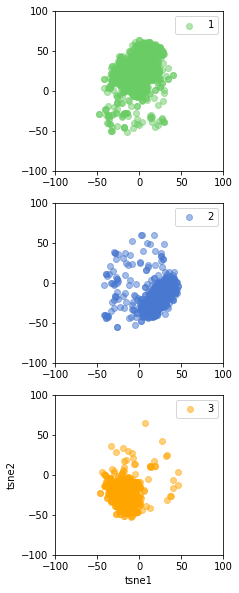

In [12]:
legendlist = []
plt.figure(figsize=(3, 10))
for i, c, label in zip(target_ids, colors[1:], target_ids):
    plt.subplot(3,1, i)
    plt.scatter(X_2d[T == i, 0], X_2d[T == i, 1], c=c, label=label, alpha=0.5)
    legendlist.append("%d : %d"%(i, sum(T==i) ) )
    plt.xlim([-100,100])
    plt.ylim([-100,100])
    plt.legend(legendlist[-1])
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.show()

/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


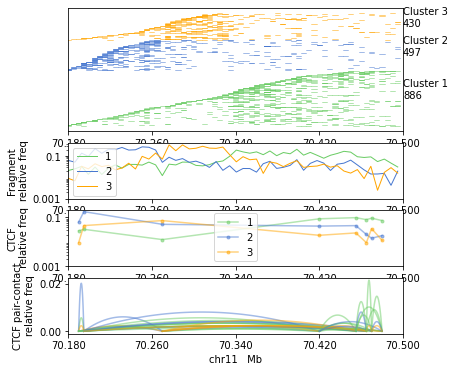

In [13]:
## Reads Cluster Figure
# 统计Cluster reads的数量
def ClusterReads(clusterDF):
    groupDF = clusterDF.groupby("Cluster")
    
    cluster_list, readcount_list = [], []
    sumreads = 0
    readcount = 0
    for cluster, gdF in groupDF:
        cluster_list.append(cluster)
        readcount = len( list(set(gdF["read_name"].to_list()) ) )
        readcount_list.append(readcount)
        sumreads += readcount
    ratio_list = [ float(c)/sumreads for c in readcount_list ]
    cluster_readcount_df = pd.DataFrame({"Cluster":cluster_list,
                                    "readcount":readcount_list,
                                    "ratio":ratio_list})
    return(cluster_readcount_df) 
 
# 统计Cluster Fragment 数量占比 分母是总reads 数 或者是 cluster分群reads数
def FragmentDensity(clusterDF, Total_reads_num):
    # cluster read counts
    cluster_readcount_df  = ClusterReads(clusterDF)
    bincount_df = clusterDF.groupby(["Cluster", "bin"], as_index=False)["read_name"].count()
    bincount_df.columns = ["Cluster", "bin", "count"]
    bincount_df["ratio"] = 0.0
    allbins = list( range( bincount_df["bin"].min(),  bincount_df["bin"].max()+1 ) )
    ## bin ratio = bincount / Total_reads_num
    for i, rcount_row in cluster_readcount_df.iterrows():
        cluster_id,  readcount = rcount_row["Cluster"], rcount_row["readcount"]
        bincount_df.loc[bincount_df.Cluster==cluster_id, "ratio"] = bincount_df.loc[bincount_df.Cluster==cluster_id, "count"].values / Total_reads_num
        # bin without fragments
        bins = bincount_df.loc[bincount_df.Cluster==cluster_id, "bin"].to_list()
        sbins = [ b for b in allbins if b not in bins ]
        sbin_df = pd.DataFrame({"Cluster":len(sbins)*[int(cluster_id)],
                                "bin": sbins,
                               "count":0,
                               "ratio":0.0})
        bincount_df = pd.concat([bincount_df, sbin_df])
    bincount_df = bincount_df.sort_values(by=["Cluster", "bin"], ignore_index=True)
    bincount_df = bincount_df.astype({"Cluster":int, "bin":int})
    # relative ratio  group total reads
    bincount_df.loc[:, "relative_ratio"] = 0.0
    for Cluster, gdf in bincount_df.groupby("Cluster"):
        g_totalreads = Cluster_reads_count.loc[Cluster_reads_count.Cluster==Cluster, "Count"][Cluster]
        P = bincount_df.Cluster == Cluster
        bincount_df.loc[P, "relative_ratio"] = bincount_df.loc[P, "count"].values / g_totalreads
    
    return(bincount_df)

from scipy.interpolate import make_interp_spline
def smoothline(x_array, y_array, smbins=100):
    '''
    smooth lines
    input: x,y array
    output: x, smooth_y array
    bigger smbins makes  
    '''
    xi = np.linspace(x_array.min(),x_array.max(),smbins)
    y_smooth =  make_interp_spline(x_array, y_array)(xi)
    return(xi, y_smooth)

read_order_df = order_DF.groupby(["Cluster","read_name"])["start"].min().reset_index()
read_order_df = read_order_df.sort_values(by=["Cluster","start"], ignore_index=True).reset_index().set_index("read_name")
order_DF.loc[:, "FragY"] = read_order_df.loc[order_DF.read_name.to_list(), "index"].values
colors = ["k","g", "b", "orange", "c", "purple",  "y", "navy"]
subsample = 5 # set subsample reads
plt.figure(figsize=(6,6))
# Cluster Figure 1
ax1 = plt.subplot(5,1,(1,2) ) 
for cluster, gdf in order_DF.groupby(["Cluster", "read_name"]):
    yn = gdf["FragY"].values[0]
    if yn % subsample == 0:
        # grey line
        read_xs = [ gdf["bin"].min()*binsize, gdf["bin"].max()*binsize]
        ys = [yn, yn ]
        #plt.plot(read_xs, ys, c="lightgrey", linewidth=0.2) link lines
        # Fragments
        for indx, rowvalue in gdf.iterrows():
            yn = rowvalue["FragY"]
            sc = colors[cluster[0]]
            #if rowvalue["binfind"] == 1:
            #    sc = "k" # ctct bin fragments black
            start = rowvalue["bin"]*binsize - 0.5*binsize
            end = rowvalue["bin"]*binsize + 0.5*binsize
            xs = [ start, end ]
            ys = [yn, yn ]
            # Fragment
            plt.plot(xs, ys, c=sc, linewidth=0.5)
plt.xticks([])
plt.yticks([])

## Cluster reads density
### Cluster reads number
Cluster_reads_count = order_DF.groupby(["read_name"])["Cluster"].first()
Cluster_reads_count = pd.DataFrame(Cluster_reads_count).reset_index()
Cluster_reads_count.columns = ["Read_name","Cluster"]
summary_count = Cluster_reads_count.Cluster.value_counts()
Cluster_reads_count = pd.DataFrame({"Cluster":summary_count.index,
                                   "Count":summary_count})
Cluster_reads_count.loc[:,"y"] = 0
for n, rowvalue in Cluster_reads_count.iterrows():
    cluster = rowvalue["Cluster"]
    cluster_count = rowvalue["Count"]
    ylist = set( order_DF.loc[order_DF.Cluster == cluster, "read_order"].to_list() )
    yvalue = sum( ylist )/len(ylist)
    Cluster_reads_count.loc[n]["y"] = yvalue
    plt.text(region[2], yvalue,  "Cluster %d\n%d"%(cluster, cluster_count) )

ax2 = plt.subplot(5,1,3, sharex=ax1)
# Calculate Bin cluster read count and bin readcounts
cluster_readcount_df = ClusterReads(order_DF)
#print(cluster_readcount_df)
All_reads_num = Cluster_reads_count.Count.sum() 
BinDensity_df = FragmentDensity(order_DF,All_reads_num)
BinDensity_df.loc[:,"BinPos"] = BinDensity_df.loc[:,"bin"].values * binsize
# Plot Density
groupDF = BinDensity_df.groupby("Cluster")
Clist = []
for cluster, gdf in groupDF:
    cluster = int(cluster)
    x, y = gdf.BinPos.values, gdf.relative_ratio.values
    x, y = smoothline(x, y, 50)
    plt.plot(x, y, c=colors[cluster], linewidth=1)
    Clist.append(cluster)
plt.legend(Clist, loc='upper left')
plt.xlim([region[1], region[2]])
plt.yscale('log')
plt.yticks([0.001, 0.1],["0.001", "0.1"])
plt.ylabel("Fragment\nrelative freq")
plt.xticks([])



# CTCF contact intensity
CTCF_DF = order_DF.loc[order_DF.binfind==1, :]
CTCF_DF.loc[:, "binPos"] =  CTCF_DF.bin.values * binsize
CTCF_DF = CTCF_DF.astype({"Cluster": "str"})
CTCFbins = list( set( CTCF_DF.binPos.to_list() ) )
CTCFbins = sorted(CTCFbins)

### CTCF relative count plot
ctcf_count = CTCF_DF.groupby(["Cluster", "binPos"], as_index=False)["read_name"].count()
ctcf_count.columns = ["Cluster", "binPos", "fcount"]

ax3 = plt.subplot(5,1,4, sharex=ax1)
Clist = []
for cluster, df in ctcf_count.groupby("Cluster"):
    x, y = df.binPos.values, df.fcount.values
    ## calculate relative ctcf percentages = ctcfbins / cluter read numbers
    y = y / summary_count[int(cluster)]
    plt.plot(x,y, linewidth=1.5, color = colors[int(cluster)], alpha=0.5, marker='.', linestyle='-')
    Clist.append(cluster)
plt.legend(Clist, loc='best')
plt.ylabel("CTCF\n relative freq")
plt.yscale('log')
plt.yticks([0.001, 0.1],["0.001", "0.1"])
plt.xticks([])


### CTCF pair contacts
import itertools
Pairs_count = {"Cluster":[],
               "read_name":[],
              "ctcf1":[],
              "ctcf2":[]}
for c1, c2 in itertools.combinations(CTCFbins, 2):
    #print (c1, c2)
    for (cluster, read_name), gdf in CTCF_DF.groupby(["Cluster", "read_name"]):
        binlist = gdf.binPos.to_list()
        if c1 in binlist and c2 in binlist:
            Pairs_count["Cluster"].append(cluster)
            Pairs_count["read_name"].append(read_name)
            Pairs_count["ctcf1"].append(c1)
            Pairs_count["ctcf2"].append(c2)
Pairs_count = pd.DataFrame(Pairs_count)
Pairs_summary = Pairs_count.groupby(["ctcf1", "ctcf2", "Cluster"])["read_name"].count().reset_index()
Pairs_summary.columns = ["ctcf1","ctcf2","Cluster","Count"]

ax4 = plt.subplot(5,1,5, sharex=ax1)
for n, rowvalue in Pairs_summary.iterrows():
    cluster = rowvalue["Cluster"]
    
    i, j  = rowvalue["ctcf1"], rowvalue["ctcf2"]
    middle = (i+j)/2
    widthsize = j-i
    weight =  rowvalue["Count"]
    weight = weight/summary_count[int(cluster)]  # relative height
    
    X = np.linspace(i,j, 50)
    #Y = ( - (X-middle)**2 + ( (widthsize/2)**2 ) )*int(cluster)
    Y = ( - (X-middle)**2 + ( (widthsize/2)**2 ) ) / (widthsize/2)**2 * float(weight)
    plt.plot(X,Y, linewidth=1.5, color = colors[int(cluster)], alpha=0.5)
plt.ylabel("CTCF pair-contact\nrelative freq")


### xticks and save 
# xlim, xticks
plt.xlim([region[1], region[2]])
# xticks
Xtick = list( np.linspace(region[1], region[2], 5 ,endpoint=True) )
Xtick_label = [ "%.3f"%(i/10**6) for i in Xtick ]
plt.xticks( Xtick, Xtick_label)
plt.xlabel("%s   Mb"%region[0] )

Exportdir = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Fig6_7_0410/%s_%d_%dGM12878"%(region[0], region[1], region[2])
os.system("mkdir -p %s"%Exportdir)
plt.savefig("%s/TAD_clusters_%s:%d-%d.pdf"%(Exportdir,  region[0], region[1], region[2]) )

/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Loading /data1/ZJY/Pore-C/HiGlass/HiCExploer/CTCFmotif/IDRpeaks/GM12878_CTCF_IDR_peaks.motif.annotation.bed


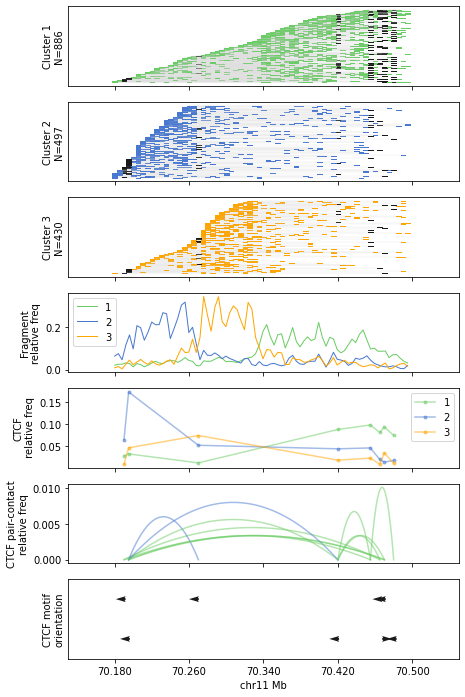

In [14]:
# Get Random sample reads
'''
1. Sample reads
2. Get reads with more than ? fragments
'''

def Reorder(df):
    '''
    Reorder read fragment by the first frag
    '''
    re_df = df.groupby(["Cluster","read_name"])["start"].min().reset_index()
    re_df = re_df.sort_values(by=["Cluster","start"], ignore_index=True).reset_index().set_index("read_name")
    df.loc[:, "FragY"] = re_df.loc[df.read_name.to_list(), "index"].values
    return(df)

from sklearn.utils import resample  

Samplerate = 0.5
Fragthred = 4
Pnum = order_DF.Fragnum >= Fragthred
SampleList = [] # Get sample reads
for cluster, gdf in order_DF.loc[Pnum].groupby(["Cluster"], as_index=False):
    Creads = list( set( gdf.read_name.to_list()  ) )  # cluter reads
    Samplenum = int( Samplerate * len(Creads) )
    Sreads = resample(Creads, n_samples=Samplenum,replace=1) # sample reads
    SampleList.append( gdf.loc[gdf.read_name.isin(Sreads) , :] )
Sampledf = pd.concat(SampleList) # Sample df
Sampledf = Reorder(Sampledf)    
 

## Cluster read numbers
Cluster_reads_count = order_DF.groupby(["read_name"])["Cluster"].first()
Cluster_reads_count = pd.DataFrame(Cluster_reads_count).reset_index()
Cluster_reads_count.columns = ["Read_name","Cluster"]
summary_count = Cluster_reads_count.Cluster.value_counts()
Cluster_reads_count = pd.DataFrame({"Cluster":summary_count.index,
                                   "Count":summary_count})    
    
# Cluster Figure 1
#plt.figure(figsize=(8,10) )
FigRow, FigCol, N = 7, 1, 1
plt.subplots(FigRow, FigCol, figsize=(7,12), sharex=True)
Axlist = []
subsample = 1
for cluster, cgdf in Sampledf.groupby("Cluster"):
    Axlist.append( plt.subplot(FigRow, FigCol, N)  )
    N += 1
    for read_name, gdf in cgdf.groupby("read_name"):
        yn = gdf["FragY"].values[0]
        if yn % subsample == 0:
            # grey line
            read_xs = [ gdf["bin"].min()*binsize, gdf["bin"].max()*binsize]
            ys = [yn, yn ]
            plt.plot(read_xs, ys, c="lightgrey", linewidth=0.2) # fragment link lines
            # Fragments
            for indx, rowvalue in gdf.iterrows():
                yn = rowvalue["FragY"]
                sc = colors[cluster]
                if rowvalue["binfind"] == 1:
                    sc = "k" # ctct bin fragments black
                start = rowvalue["bin"]*binsize - 0.5*binsize
                end = rowvalue["bin"]*binsize + 0.5*binsize
                xs = [ start, end ]
                ys = [yn, yn ]
                # Fragment
                plt.plot(xs, ys, c=sc, linewidth=1)
    plt.xticks([])
    plt.yticks([])
    readnum = summary_count[cluster]
    plt.ylabel( "Cluster %d\nN=%d"%(cluster, readnum) )

    
Axlist.append( plt.subplot(FigRow, FigCol, N)  )
N += 1
# Calculate Bin cluster read count and bin readcounts
cluster_readcount_df = ClusterReads(order_DF)
#print(cluster_readcount_df)
All_reads_num = Cluster_reads_count.Count.sum() 
BinDensity_df = FragmentDensity(order_DF,All_reads_num)
BinDensity_df.loc[:,"BinPos"] = BinDensity_df.loc[:,"bin"].values * binsize
# Plot Density
groupDF = BinDensity_df.groupby("Cluster")
Clist = []
for cluster, gdf in groupDF:
    cluster = int(cluster)
    x, y = gdf.BinPos.values, gdf.relative_ratio.values
    x, y = smoothline(x, y, 80)
    plt.plot(x, y, c=colors[cluster], linewidth=1)
    Clist.append(cluster)
plt.legend(Clist, loc='upper left')
#plt.xlim([region[1], region[2]])
#plt.yscale('log')
#plt.yticks([0.001, 0.1],["0.001", "0.1"])
plt.ylabel("Fragment\nrelative freq")
plt.xticks([])


# CTCF contact intensity
CTCF_DF = order_DF.loc[order_DF.binfind==1, :]
CTCF_DF.loc[:, "binPos"] =  CTCF_DF.bin.values * binsize
CTCF_DF = CTCF_DF.astype({"Cluster": "str"})
CTCFbins = list( set( CTCF_DF.binPos.to_list() ) )
CTCFbins = sorted(CTCFbins)
### CTCF relative count plot
ctcf_count = CTCF_DF.groupby(["Cluster", "binPos"], as_index=False)["read_name"].count()
ctcf_count.columns = ["Cluster", "binPos", "fcount"]
### CTCF pair contacts
import itertools
Pairs_count = {"Cluster":[],
               "read_name":[],
              "ctcf1":[],
              "ctcf2":[]}
for c1, c2 in itertools.combinations(CTCFbins, 2):
    #print (c1, c2)
    for (cluster, read_name), gdf in CTCF_DF.groupby(["Cluster", "read_name"]):
        binlist = gdf.binPos.to_list()
        if c1 in binlist and c2 in binlist:
            Pairs_count["Cluster"].append(cluster)
            Pairs_count["read_name"].append(read_name)
            Pairs_count["ctcf1"].append(c1)
            Pairs_count["ctcf2"].append(c2)
Pairs_count = pd.DataFrame(Pairs_count)
Pairs_summary = Pairs_count.groupby(["ctcf1", "ctcf2", "Cluster"])["read_name"].count().reset_index()
Pairs_summary.columns = ["ctcf1","ctcf2","Cluster","Count"]
## pairs filter 
'''
ctcf pair count >= 3
ctcf pair region >= 25kb
'''
Pairs_summary = Pairs_summary.loc[Pairs_summary.Count >= 3, :]
Psize = abs( Pairs_summary.ctcf1.values - Pairs_summary.ctcf2.values ) >= 25000
Pairs_summary = Pairs_summary.loc[Psize, :]

## CTCF freq figure
Axlist.append( plt.subplot(FigRow, FigCol, N)  )
N += 1
Clist = []
for cluster, df in ctcf_count.groupby("Cluster"):
    x, y = df.binPos.values, df.fcount.values
    ## calculate relative ctcf percentages = ctcfbins / cluter read numbers
    y = y / summary_count[int(cluster)]
    plt.plot(x,y, linewidth=1.5, color = colors[int(cluster)], alpha=0.5, marker='.', linestyle='-')
    Clist.append(cluster)
plt.legend(Clist, loc='best')
plt.ylabel("CTCF\n relative freq")
#plt.yscale('log')
#plt.yticks([0.001, 0.1],["0.001", "0.1"])
plt.xticks([])
#plt.xlim([region[1], region[2]])


## CTCF pairs contact
Axlist.append( plt.subplot(FigRow, FigCol, N)  )
N += 1
for n, rowvalue in Pairs_summary.iterrows():
    cluster = rowvalue["Cluster"]
    i, j  = rowvalue["ctcf1"], rowvalue["ctcf2"]
    middle = (i+j)/2
    widthsize = j-i
    weight =  rowvalue["Count"]
    weight = weight/summary_count[int(cluster)]  # relative height
    X = np.linspace(i,j, 50)
    #Y = ( - (X-middle)**2 + ( (widthsize/2)**2 ) )*int(cluster)
    Y = ( - (X-middle)**2 + ( (widthsize/2)**2 ) ) / (widthsize/2)**2 * float(weight)
    plt.plot(X,Y, linewidth=1.5, color = colors[int(cluster)], alpha=0.5)
plt.ylabel("CTCF pair-contact\nrelative freq")
#plt.yscale('log')

## CTCF motif orientations
# loading ctcf motif information
ctcf_motif_file="/data1/ZJY/Pore-C/HiGlass/HiCExploer/CTCFmotif/IDRpeaks/GM12878_CTCF_IDR_peaks.motif.annotation.bed"
motifDF = Loadingbed(ctcf_motif_file, region, binsize, ["chrom", "start", "end","strand"], [0,1,2,5] )
motifDF = motifDF.sort_values(by="pos", ignore_index=True)

Axlist.append( plt.subplot(FigRow, FigCol, N)  )
N += 1
y = 1
for n, rowvalue in motifDF.iterrows():
    x, strand_val = rowvalue["pos"], rowvalue["strand"]
    x_u = 1
    if strand_val == "-":
        x_u = -1
    plt.quiver(x,y,x_u,0, scale=40) # arrow, + , -
    y = y*(-1) # two lines
plt.yticks([])
plt.ylim([-2, 2])
plt.xticks([])
plt.ylabel("CTCF motif\norientation")

flank = 0.05*10**6
plt.xlim([region[1]-flank, region[2]+flank])
# xticks
Xtick = list( np.linspace(region[1], region[2], 5 ,endpoint=True) )
Xtick_label = [ "%.3f"%(i/10**6) for i in Xtick ]
plt.xticks( Xtick, Xtick_label)
plt.xlabel("%s Mb"%region[0] )
#plt.show()

Exportdir = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Fig6_7_0410/%s_%d_%dGM12878"%(region[0], region[1], region[2])
os.system("mkdir -p %s"%Exportdir)
plt.savefig("%s/TAD_clusters_%s:%d-%d_v1.pdf"%(Exportdir,  region[0], region[1], region[2]) )

In [36]:
### CTCF pair contacts
motifdict = {}
for n, rowdf in motifDF.iterrows():
    binID, strand = int(rowdf["bin"]*binsize), rowdf["strand"]
    motifdict[binID] = strand
## ctcf combination pattern()
ctcfPattern ={"--":"tendom",
              "++":"tendom",
              "+-":"convergen",
              "-+":"divergen"}
import itertools
Pairs_count = {"Cluster":[],
               "read_name":[],
              "ctcf1":[],
              "ctcf2":[],
               "ctcf_combin":[],
              "ctcf_pattern":[]}
for c1, c2 in itertools.combinations(CTCFbins, 2):
    #print (c1, c2)
    for (cluster, read_name), gdf in CTCF_DF.groupby(["Cluster", "read_name"]):
        binlist = gdf.binPos.to_list()
        if c1 in binlist and c2 in binlist:
            Pairs_count["Cluster"].append(cluster)
            Pairs_count["read_name"].append(read_name)
            Pairs_count["ctcf1"].append(c1)
            Pairs_count["ctcf2"].append(c2)
            # orientation
            try:
                ctcf_combin = motifdict[c1] + motifdict[c2]
                ctcf_p = ctcfPattern[ctcf_combin]
            except:
                ctcf_combin = "Unknown"
                ctcf_p = "Unknown"
            Pairs_count["ctcf_combin"].append(ctcf_combin)
            Pairs_count["ctcf_pattern"].append(ctcf_p)
            
Pairs_count = pd.DataFrame(Pairs_count)
## filter 20kb ctcf pairs
Psize = abs( Pairs_count.ctcf1.values - Pairs_count.ctcf2.values ) >= 20000
Pairs_count = Pairs_count.loc[Psize, :]
Pairs_count  = Pairs_count.loc[Pairs_count.ctcf_combin != "Unknown", :]

PatternSummary = {"Cluster":[], 
                  "AllelPattern":[]}
for read_name, df in Pairs_count.groupby("read_name"):
    Cluster = df["Cluster"].iloc[0]
    patterns = df["ctcf_pattern"].to_list()
    if len(patterns) >= 2:
        p1 = "multi:"
    else:
        p1 = "single:"
    set_pattern = list( set(patterns) )
    if len(set_pattern) >= 2:
        p2 = "+".join(set_pattern)
    else:
        p2 = set_pattern[0]
    AllelPattern = p1+p2
    PatternSummary["Cluster"].append(Cluster)
    PatternSummary["AllelPattern"].append(AllelPattern )
PatternSummary = pd.DataFrame(PatternSummary)    

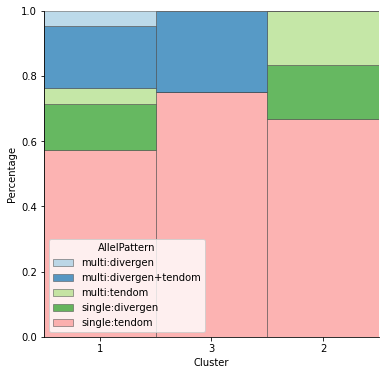

In [47]:
PatternSummary  = PatternSummary.sort_values(["AllelPattern"])
f, ax = plt.subplots(figsize=(6, 6))
sns.despine(f)
sns.histplot(
    PatternSummary,
    x="Cluster", hue="AllelPattern",
    multiple="fill",
    palette="Paired",
    edgecolor=".3",
    linewidth=.5)
plt.ylabel("Percentage")
plt.savefig("%s/TAD_clusters_%s:%d-%d_CTCF_pattern.pdf"%(Exportdir,  region[0], region[1], region[2]) )

In [38]:
Pairs_count.sort_values("read_name")

,Cluster,read_name,ctcf1,ctcf2,ctcf_combin,ctcf_pattern
61,1,036249fa-82a3-49d8-8a25-7c2e4a1f65d9,70270000,70465000,-+,divergen
57,1,04f0c643-b8f0-4936-96b1-577fc273634b,70270000,70420000,--,tendom
79,1,0bb767e7-baed-4c22-b243-95ecd82016df,70420000,70480000,--,tendom
52,1,142048cb-0048-4a24-b9f1-e572159b5d6b,70195000,70480000,--,tendom
37,2,31bc3745-476e-472f-a1db-2c02ac7f85c6,70195000,70420000,--,tendom
54,2,31bc3745-476e-472f-a1db-2c02ac7f85c6,70195000,70480000,--,tendom
80,2,31bc3745-476e-472f-a1db-2c02ac7f85c6,70420000,70480000,--,tendom
32,1,3c9d91a4-2bd3-4285-a797-74855a378f27,70195000,70420000,--,tendom
78,2,3cdb4823-14ac-419f-857f-dcc05d8dc5f3,70420000,70470000,--,tendom
46,1,3ce92a4f-6d48-4150-92c3-787cb28973cb,70195000,70465000,-+,divergen


In [21]:
Pairs_count

,Cluster,read_name,ctcf1,ctcf2
0,1,1448164e-f04b-45de-94a4-c79d276e4f70,70190000,70195000
1,1,3ce92a4f-6d48-4150-92c3-787cb28973cb,70190000,70195000
2,1,a223fcac-73a7-4d2a-baf0-46c36d75b52a,70190000,70195000
3,1,aba84125-854d-411a-acde-2b1b60a3221e,70190000,70195000
4,1,df79ac6c-35e3-4a21-bf40-ba6dd977a176,70190000,70195000
...,...,...,...,...
151,1,c35d23a8-2e66-498a-8969-257270d8b884,70470000,70480000
152,1,df462ce1-1d66-49d5-9451-55f476f45489,70470000,70480000
153,2,d3a68aae-f90f-45cf-8206-adae3a9f9c8d,70470000,70480000
154,2,f7245fb3-8c07-45ea-b206-cfdd63504dd7,70470000,70480000


In [51]:
# Export cluster vdFragments
Generate_Contactpy = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Generate_Contact_juiceMatrix_vdF.py"
Generate_coolsh = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Generate_cool.sh"
export_cols =  ["read_name","read_start","read_end","strand","chrom","start","end","MapQual","LRvdF_pfix"]
# clear all vdFragment files coolfiles in the Exoportdir
os.system("mkdir -p %s"%Exportdir)
#os.system( "rm %s/*._juice_matrix.txt"%(Exportdir))
#os.system( "rm %s/*.cool"%(Exportdir))
#os.system( "rm %s/*.mcool"%(Exportdir))

## Generate juicematrix
for cluster, df in  order_DF.groupby("Cluster"):
    inputfile = Exportdir + "/" +"vdFragment.csv"
    juice_matrix = Exportdir + "/" + "C%d_juice_matrix.txt"%(cluster)
    # export vdFragment.csv 
    clt_VDF_DF = df.loc[:, export_cols]
    clt_VDF_DF.to_csv(inputfile, sep=",", header=True, index=False )
    # python <Generate_Contactpy> <inputfile> <juice_matrix> 
    os.system( "python %s %s %s"%(Generate_Contactpy, inputfile, juice_matrix) )  
    os.system( "bash %s %s %s"%(Generate_coolsh, Exportdir, juice_matrix) ) 

Generate Contact Matrix for /data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Fig6_7_0410/chr11_70180000_70500000GM12878/vdFragment.csv
Loading 836 reads and 4298 fragments
2022--04--22 14:18:38
Processing reads: 0 - 836
Generate Contact
Generated 10089 pairs contacts in 20000 reads.
Finished! 
Therotically it can produce 10089 contact pairs.
Run C1


  is_cat = pd.api.types.is_categorical(bins['chrom'])

INFO:cooler.create:Writing chunk 0: /data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Fig6_7_0410/chr11_70180000_70500000GM12878/tmp0pe4q2ft.multi.cool::0


Generate Contact Matrix for /data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Fig6_7_0410/chr11_70180000_70500000GM12878/vdFragment.csv
Loading 454 reads and 2283 fragments
2022--04--22 14:18:44
Processing reads: 0 - 454
Generate Contact
Generated 5170 pairs contacts in 20000 reads.
Finished! 
Therotically it can produce 5170 contact pairs.
Run C2


INFO:cooler.create:Creating cooler at "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Fig6_7_0410/chr11_70180000_70500000GM12878/tmp0pe4q2ft.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Done
INFO:cooler.create:Merging into C1.cool
  is_cat = pd.api.types.is_categorical(bins['chrom'])

INFO:cooler.create:Creating cooler at "C1.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins


Generate Contact Matrix for /data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Fig6_7_0410/chr11_70180000_70500000GM12878/vdFragment.csv
Loading 523 reads and 2756 fragments
2022--04--22 14:18:48
Processing reads: 0 - 523
Generate Contact
Generated 6568 pairs contacts in 20000 reads.
Finished! 
Therotically it can produce 6568 contact pairs.
Run C3


INFO:cooler.create:Writing chunk 0: /data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Fig6_7_0410/chr11_70180000_70500000GM12878/tmp9qrmly80.multi.cool::0
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:nnzs: [1660]
INFO:cooler.reduce:current: [1660]
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Done
INFO:cooler.cli.zoomify:Recursively aggregating "C1.cool"
INFO:cooler.cli.zoomify:Writing to "C1.mcool"
  is_cat = pd.api.types.is_categorical(bins['chrom'])

INFO:cooler.reduce:Copying base matrices and producing 4 new zoom levels.
INFO:cooler.reduce:Bin size: 1000
INFO:cooler.reduce:Aggregating from 1000 to 10000.
INFO:cooler.create:Creating cooler at "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Cluster/Fig6_7_0410/chr11_70180000_70500000GM12878/tmp9qrmly80.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:c

INFO:cooler.balance:variance is 1356.7388303683613
INFO:cooler.balance:variance is 54.04486263011968
INFO:cooler.balance:variance is 2.6773233268613676
INFO:cooler.balance:variance is 0.15856982624929783
INFO:cooler.balance:variance is 0.010957411221204427
INFO:cooler.balance:variance is 0.0008386366374539091
INFO:cooler.balance:variance is 6.819859301073703e-05
INFO:cooler.balance:variance is 5.729253237967822e-06
INFO:cooler.cli.zoomify:Balancing zoom level with bin size 25000
INFO:cooler.balance:variance is 755.8529715166413
INFO:cooler.cli.balance:Balancing "C1.mcool::resolutions/25000"
INFO:cooler.balance:variance is 117102.33136094674
INFO:cooler.balance:variance is 9241.223505562692
INFO:cooler.balance:variance is 853.8393551554339
INFO:cooler.balance:variance is 78.1501731306186
INFO:cooler.balance:variance is 7.194809895928149
INFO:cooler.balance:variance is 0.6680225866164629
INFO:cooler.balance:variance is 0.062383949079569304
INFO:cooler.balance:variance is 0.00584518966354